In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, ITransformer
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
#logging.debug("info")

/home/agobbi/Projects/TS/new_pl/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#read a public dataset
data, columns = read_public_dataset('/home/agobbi/Projects/ExpTS/data','venice')

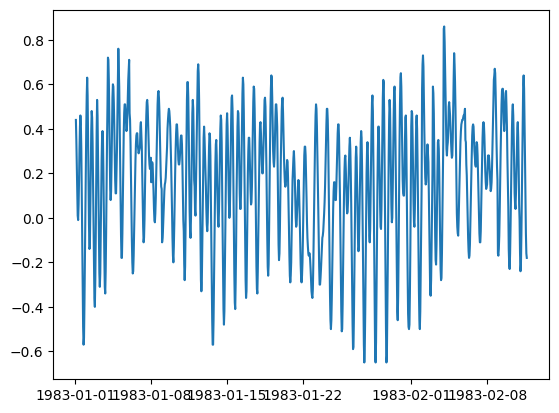

In [4]:

plt.plot(data.time[0:1000],data.y[0:1000])

In [5]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('venice')
ts.load_signal(data,enrich_cat=['hour'],target_variables=['y'],past_variables=[])


In [ ]:
ts.past_variables


In [ ]:
fig = ts.plot()

In [7]:
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 12*7
future_steps = 12*7


In [11]:
#Itransformer


config = dict(model_configs =dict(
                                    d_model = 16,
                                    n_head=4,
                                    hidden_size = 64,
                                    class_strategy = 'projection',
                                    n_layer_decoder = 4,
                                    use_norm = True,
                                    optim= 'torch.optim.Adam',
                                    past_steps = past_steps,
                                    future_steps = future_steps,
                                    past_channels = len(ts.num_var),
                                    future_channels = len(ts.future_variables),
                                    embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                    quantiles= [],
                                    persistence_weight= 0.010,
                                    loss_type= 'l1',
                                    activation= 'torch.nn.PReLU',                            
                                    out_channels = len(ts.target_variables)),             #parameter that depends on the ts dataset
                scheduler_config = dict(gamma=0.1,step_size=100),
                optim_config = dict(lr = 0.0005,weight_decay=0.01))
model = ITransformer(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'],verbose=False )


In [12]:
#set the desirere model
ts.set_model(model,config=config )

In [13]:
##splitting parameters
split_params = {'perc_train':0.7,'perc_valid':0.1,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

/home/agobbi/Projects/TS/new_pl/.venv/lib/python3.11/site-packages/aim/ext/utils.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Seed set to 42
/home/agobbi/Projects/TS/new_pl/.venv/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/agobbi/Projects/TS/new_pl/.venv/lib/python3.11/site-packages/li

Saving losses on file because multigpu not working


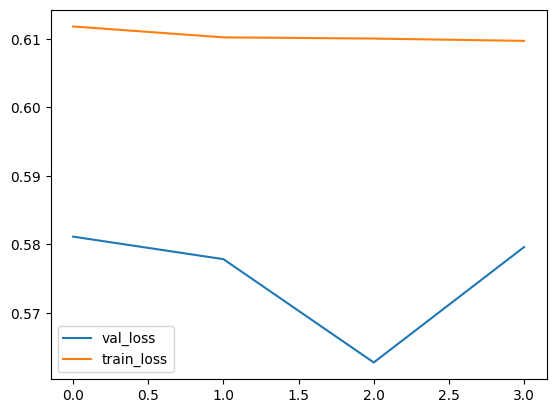

In [14]:
#train the model for 50 epochs with auto_lr_find 
if True:
    ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/tmp/venice",
                   split_params=split_params,
                   batch_size=128,
                   num_workers=4,
                   max_epochs=5,
                   gradient_clip_val= 0.0,
                   gradient_clip_algorithm='value',
                   precision='bf16',
                   auto_lr_find=True)
    #Print the losses, check overfitting
    ts.losses.plot()
    ts.save(f"venice_test")

In [15]:
#make inferences on 
retrain=True
if retrain:
    res = ts.inference_on_set(200,4,set='test',rescaling=True)
    import numpy as np
    res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}) 

AttributeError: 'DataFrame' object has no attribute 'y_median'

In [2]:
res = pd.read_csv('/home/agobbi/test_venice_test_tot_predictions.csv')
res

,Unnamed: 0,lag,time,y,y_pred,prediction_time,model
0,0,1,2015-10-23 13:00:00,0.23,0.294126,2015-10-23 12:00:00,itransformer_test_venice_1
1,1,1,2015-10-24 02:00:00,0.03,0.193400,2015-10-24 01:00:00,itransformer_test_venice_1
2,2,1,2015-10-24 15:00:00,-0.01,0.157257,2015-10-24 14:00:00,itransformer_test_venice_1
3,3,1,2015-10-25 04:00:00,0.15,0.234469,2015-10-25 03:00:00,itransformer_test_venice_1
4,4,1,2015-10-25 17:00:00,0.06,0.161349,2015-10-25 16:00:00,itransformer_test_venice_1
...,...,...,...,...,...,...,...
920299,920299,84,2023-12-29 16:00:00,-0.03,0.397989,2023-12-26 04:00:00,duet_test_venice_1
920300,920300,84,2023-12-30 05:00:00,0.32,0.403182,2023-12-26 17:00:00,duet_test_venice_1
920301,920301,84,2023-12-30 18:00:00,-0.23,0.314011,2023-12-27 06:00:00,duet_test_venice_1
920302,920302,84,2023-12-31 07:00:00,0.29,0.300457,2023-12-27 19:00:00,duet_test_venice_1


In [8]:
gg = res.groupby(['lag','model']).apply(lambda x:((x.y-x.y_pred)**2).mean()).reset_index()

/tmp/ipykernel_73919/3899777088.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gg = res.groupby(['lag','model']).apply(lambda x:((x.y-x.y_pred)**2).mean()).reset_index()


In [9]:
gg

,lag,model,0
0,1,duet_test_venice_1,0.019778
1,1,itransformer_test_venice_1,0.008987
2,2,duet_test_venice_1,0.024367
3,2,itransformer_test_venice_1,0.011124
4,3,duet_test_venice_1,0.028437
...,...,...,...
163,82,itransformer_test_venice_1,0.059560
164,83,duet_test_venice_1,0.061067
165,83,itransformer_test_venice_1,0.057023
166,84,duet_test_venice_1,0.061278


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

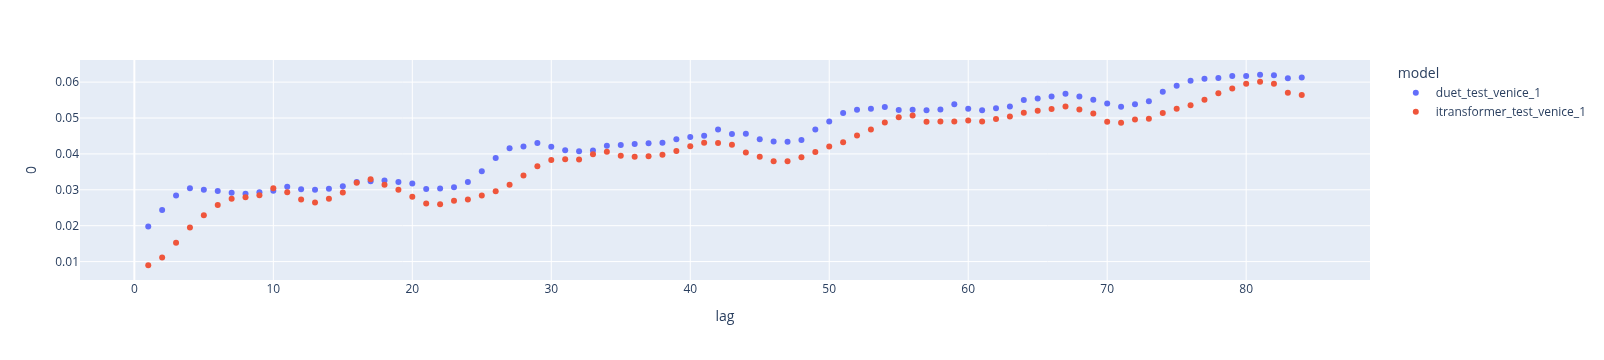

In [20]:
import plotly.express as px
px.scatter(gg,x='lag', y=0,color='model')

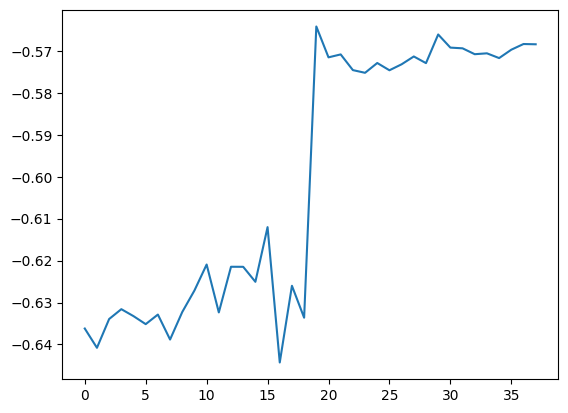

In [28]:
plt.plot(res.loss)

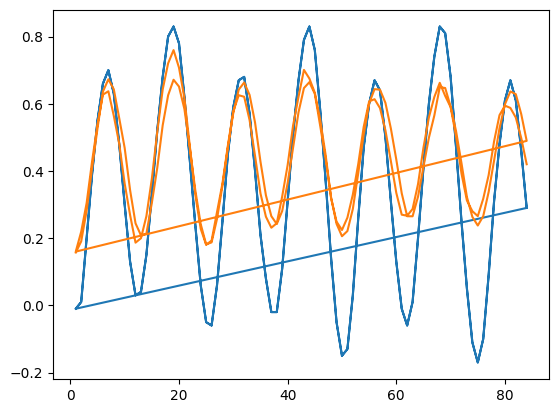

In [3]:
plt.plot(res[res.prediction_time=='2015-10-24 14:00:00'].lag,res[res.prediction_time=='2015-10-24 14:00:00'].y)
plt.plot(res[res.prediction_time=='2015-10-24 14:00:00'].lag,res[res.prediction_time=='2015-10-24 14:00:00'].y_pred)

In [35]:
model.__class__.load_from_checkpoint('/home/agobbi/Projects/ExpTS/tmp/venice/checkpoint-v1.ckpt')


ITransformer(
  (loss): L1Loss()
  (embs): ModuleList(
    (0): Embedding(25, 16)
  )
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=84, out_features=16, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=16, out_features=16, bias=True)
          (key_projection): Linear(in_features=16, out_features=16, bias=True)
          (value_projection): Linear(in_features=16, out_features=16, bias=True)
          (out_projection): Linear(in_features=16, out_features=16, bias=True)
        )
        (conv1): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affin

In [20]:
try:
    import lightning.pytorch as pl
    OLD_PL = False
except:
    import pytorch_lightning as pl
    OLD_PL = True
OLD_PL

False

In [19]:
 res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}) 

/tmp/ipykernel_711676/578648829.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'})


,lag,error
0,1,0.016097
1,2,0.020034
2,3,0.025412
3,4,0.027479
4,5,0.029943
...,...,...
79,80,0.059693
80,81,0.060633
81,82,0.059748
82,83,0.061305


In [ ]:
## get the median MSE for each lag


In [ ]:
#save model 


In [ ]:
## load the model and check if we obtain the same result

In [ ]:
data

In [ ]:
ts.load(LinearTS,f"venice_test",load_last=False)
#res = ts.inference_on_set(200,4,set='test',rescaling=True)
#error = res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 
#error

In [ ]:
future_steps

In [ ]:
past_steps

In [ ]:
tmp

In [ ]:
empty

In [ ]:
inference_data

In [ ]:
##print the mean MSE along the lag steps
#plt.plot(error.lag,error.error)

In [ ]:
tmp = data[data.time>'2021-12-28 12:00:00']
tmp['hour'] = tmp.time.dt.hour

empty = pd.DataFrame({'time':pd.date_range(tmp.time.max()+timedelta(hours=1),tmp.time.max()+timedelta(hours=future_steps),freq='1h'),
                      'y':np.nan}) ##this is a bug, you can 
empty['hour'] = empty.time.dt.hour
inference_data = pd.concat([tmp,empty])

In [ ]:
tmp

In [ ]:
inference_data ##I can extend the dataset

In [ ]:
ts.inference(data = inference_data,is_inference=True)

In [ ]:
tmp ##or just start from it and DSIPTS will automatically add categorical temporal variable

In [ ]:
ts.inference(data = tmp,steps_in_future=future_steps,is_inference=True)

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = res
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = res[res.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_median,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()